In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
import keras
from keras import layers

In [2]:
# upload data
df = pd.read_csv("balanced_dataset.csv")
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,20.34,0,0,1,0,0,0,0,80,0,0,1,3,7,0,0,0
1,0,24.21,0,0,0,0,0,0,0,77,0,0,0,2,6,0,0,1
2,0,31.64,1,0,0,5,0,1,0,80,0,2,0,2,9,1,0,0
3,0,28.37,1,0,0,0,0,1,1,77,0,2,1,3,8,0,0,0
4,0,28.15,0,0,0,7,0,1,0,80,0,0,0,2,7,0,0,0


In [3]:
# printing out the column names for easier copying for X/y
df.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

In [4]:
#  X/y -variables

# if you  have more than one independent variables, list them all here
# leave out the target variable! (dependent variable)
# in this case, everything else except the amount_paid
X = df[['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer']]

# have only the target variable here (dependent variable)
# in this case, amount_paid => how big is the electricity bill
y = df['HeartDisease']

In [5]:
#  Train/test/validation -split

# unfortunately the scikit-learn's train_test_split doesn't support validation
# set split in itself.
# if you want to split the test set into two for a validation set too, try this trick:

# first, train/test split => 70% for training, 30% for other purposes (temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101)

# now, split the 30% for other purposes by 50% (resulting in 2 x 15%)
# so finally, we have:
# 70% for training
# 15% for testing
# 15% for validation
# => 70 + 15 +15 = 100%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=101)

In [6]:
# just seeing how much data we have in each
print(f"Train data amount: {len(X_train)}")
print(f"Test data amount: {len(X_test)}")
print(f"Validation data amount: {len(X_val)}")

Train data amount: 139688
Test data amount: 29934
Validation data amount: 29933


In [7]:
#  Create neural network structure
variable_amount = len(X.columns)

# Define Sequential neural network model
# I have 18 columns --> 18 - 1 = 17 input layers
# I have 2 options for output (Yes or No for Heart disease)
# --> 2 output layers

# I want to try later add one activation functionii
# activation="softmax" for the last layer
model_1 = keras.Sequential(
    [
        layers.Dense(7, activation="relu", input_shape=(variable_amount,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(2)
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
# i want to try also loss='categorical_crossentropy', metrics=['accuracy']
model_1.compile(optimizer='adam', loss='mse')

# print out the summary of your model
model_1.summary()

C:\Users\e1003118\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 7)              │           126 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 944 (3.69 KB)

 Trainable params: 944 (3.69 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#  Train the neural network with our data

 # using validation again for better metrics and optimization
model_1.fit(x=X_train, y=y_train, epochs=400, validation_data=(X_val, y_val))

Epoch 1/400
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 4s 873us/step - loss: 0.0930 - val_loss: 0.0632
Epoch 2/400
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 4s 958us/step - loss: 0.0630 - val_loss: 0.0610
Epoch 3/400
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0608 - val_loss: 0.0597
Epoch 4/400
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 4s 868us/step - loss: 0.0602 - val_loss: 0.0601
Epoch 5/400
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 4s 852us/step - loss: 0.0603 - val_loss: 0.0596
Epoch 6/400
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 4s 836us/step - loss: 0.0599 - val_loss: 0.0600
Epoch 7/400
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 4s 847us/step - loss: 0.0601 - val_loss: 0.0595
Epoch 8/400
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 4s 848us/step - loss: 0.0596 - val_loss: 0.0594
Epoch 9/400
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 4s 870us/step - loss: 0.0596 - val_loss: 0.0595
Epoch 10/400
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 4s 875us/step - loss: 0.0605 - val_loss: 0.0598
Epoch 11/400
4366/4366 ━━━━━━━━━━━━━━━━━━━━ 4s 843us/step - loss: 0.0590 - val_loss: 0.0594

<Axes: >

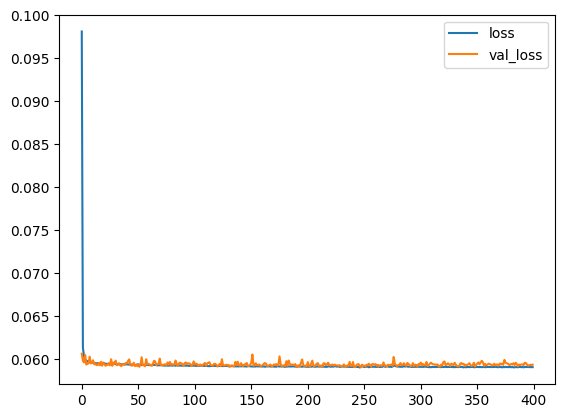

In [12]:
#  Training metrics
loss_df = pd.DataFrame(model_1.history.history)
loss_df.plot()

# the validation loss stays close to the training loss 
# without large gaps indicates 
# that the model is not overfitting

# Both the training and validation loss values are low, 
# which suggests the model is learning effectively 
# and minimizing errors

In [14]:
 # compare test error values to training error values
# the model is often good when these error values are similar
# even if you training metrics above didn't overlap
# you might still get very close values in evaluation => more important

# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model_1.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model_1.evaluate(X_train, y_train, verbose=0))

# The train loss (0.0589) and test loss (0.0595) are very close
# this is a good sign :)

Test data evaluation:
0.05950901284813881

Train data evaluation:
0.058918923139572144


In [15]:
test_predictions = model_1.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

936/936 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step


ValueError: cannot reshape array of size 59868 into shape (29934,)

In [16]:
 # these values follow a linear line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

NameError: name 'pred_df' is not defined

In [ ]:
#  Regression error metrics
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

In [ ]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()